Loading checkpoint 'checkpoint.pth.tar'
Checkpoint loaded in 0.14144086837768555 seconds
Checkpoint loading took 0.15174269676208496 seconds


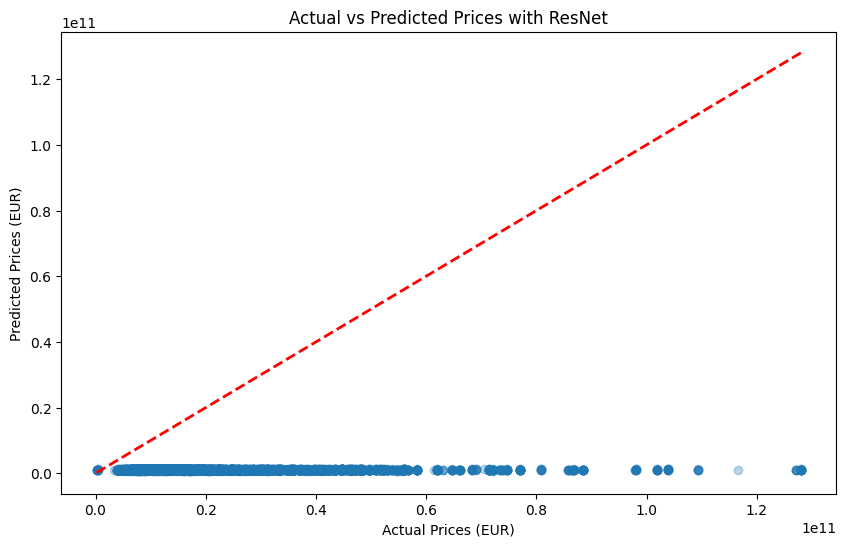

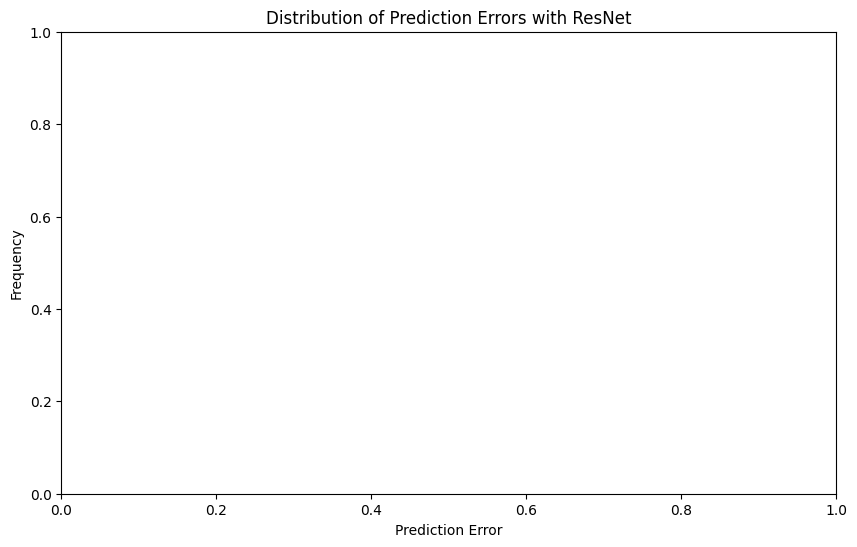

In [23]:
import sys
import time
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from early_stopping import EarlyStopping

# Function to load checkpoint
def load_checkpoint(filename="checkpoint.pth.tar"):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        start_time = time.time()
        checkpoint = torch.load(filename)
        print(f"Checkpoint loaded in {time.time() - start_time} seconds")
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        return start_epoch
    else:
        print(f"No checkpoint found at '{filename}'")
        return 0

# Učitavanje CSV fajla sa cenama
data = pd.read_csv('filtered_property_data.csv')

# Normalizacija ciljne promenljive (cena)
scaler = StandardScaler()
data['cena'] = scaler.fit_transform(data[['cena']])

# Definisanje transformacija za slike
transform = transforms.Compose([
    transforms.Resize(512),  # Povećanje rezolucije na 512x512
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Definisanje dataset klase
class PropertyImageDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.prices = []

        # Iteriranje kroz svaki folder i povezivanje slika sa cenama
        for folder in ['kupatilo', 'kuhinja', 'sobe', 'terasa']:
            folder_path = os.path.join(image_dir, folder)
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('png', 'jpg', 'jpeg')):
                    img_id = img_name.split('_')[0]
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    price = self.data[self.data['id'] == img_id]['cena']
                    if not price.empty:
                        self.prices.append(price.values[0])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        price = self.prices[idx]
        price = torch.tensor(price, dtype=torch.float)  # Konvertovanje cene u Float
        
        return image, price

# Kreiranje dataset-a i data loader-a
image_dir = 'property_images'
csv_file = 'filtered_property_data.csv'
dataset = PropertyImageDataset(csv_file=csv_file, image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Učitavanje pretreniranog ResNet modela
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in resnet.parameters():
    param.requires_grad = False

# Modifikacija poslednjeg sloja za ekstrakciju karakteristika
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 1)  # Dodajemo sloj za predikciju cene

# Inicijalizacija modela
model = resnet

# Definisanje loss funkcije i optimizatora
criterion = nn.MSELoss()

# Funkcija za izračunavanje Mean Absolute Error (MAE)
def mean_absolute_error(preds, targets):
    return torch.mean(torch.abs(preds - targets))

# Funkcija za izračunavanje Mean Squared Error (MSE)
def mean_squared_error(preds, targets):
    return torch.mean((preds - targets) ** 2)

# Prikaz MAE u procentima
average_price = data['cena'].mean()  # Prosečna cena iz CSV fajla

# Funkcija za čuvanje stanja modela
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)

# Dodavanje early stopping-a
early_stopping = EarlyStopping(patience=5, verbose=True)

# Proveri da li postoji checkpoint
checkpoint_exists = os.path.isfile("checkpoint.pth.tar")

if not checkpoint_exists:
    # Istraživanje različitih stopa učenja i optimizatora
    learning_rates = [0.001, 0.0001]
    optimizers = ['adam', 'sgd']

    for lr in learning_rates:
        for opt in optimizers:
            print(f'Training with learning rate: {lr} and optimizer: {opt}')
            if opt == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            # Učitavanje prethodno sačuvanog stanja ako postoji
            start_epoch = load_checkpoint()

            # Treniranje modela
            num_epochs = 50  # Povećajte broj epoha
            for epoch in range(start_epoch, num_epochs):
                model.train()
                running_loss = 0.0
                running_mae = 0.0
                running_mse = 0.0
                
                # Dodavanje progress bar-a za iteracije unutar epoha
                for images, prices in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
                    images = images
                    prices = prices
                    optimizer.zero_grad()
                    outputs = model(images).squeeze()
                    loss = criterion(outputs, prices)
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item() * images.size(0)
                    running_mae += mean_absolute_error(outputs, prices).item() * images.size(0)
                    running_mse += mean_squared_error(outputs, prices).item() * images.size(0)
                
                epoch_loss = running_loss / len(dataset)
                epoch_mae = running_mae / len(dataset)
                epoch_mse = running_mse / len(dataset)
                epoch_mae_percentage = (epoch_mae / average_price) * 100
                
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, MAE: {epoch_mae:.4f} ({epoch_mae_percentage:.2f}%), MSE: {epoch_mse:.4f}')
                
                # Čuvanje stanja modela nakon svakog epoha
                save_checkpoint({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                })
                
                # Provera za early stopping
                early_stopping(epoch_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    break

else:
    start_time = time.time()
    start_epoch = load_checkpoint()
    print(f"Checkpoint loading took {time.time() - start_time} seconds")

# Vizualizacija stvarnih vs. predikcija cena
model.eval()
actual_prices = []
predicted_prices = []
with torch.no_grad():
    for images, prices in dataloader:
        outputs = model(images).squeeze()
        actual_prices.extend(prices.numpy())
        predicted_prices.extend(outputs.numpy())

# Inverse transform the normalized prices to get actual prices
actual_prices = scaler.inverse_transform(np.array(actual_prices).reshape(-1, 1)).flatten()
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

# Save predictions to CSV
predictions_df = pd.DataFrame({'actual_prices': actual_prices, 'predicted_prices': predicted_prices})
predictions_df.to_csv('resnet_predictions.csv', index=False)

# Plotting actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(actual_prices, predicted_prices, alpha=0.3)
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], 'r--', lw=2)
plt.xlabel('Actual Prices (EUR)')
plt.ylabel('Predicted Prices (EUR)')
plt.title('Actual vs Predicted Prices with ResNet')
plt.show()

# Plotting distribution of errors
errors = actual_prices - predicted_prices
plt.figure(figsize=(10, 6))
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors with ResNet')
plt.show()
